In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
import json

def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b


def main(ticker):
    shop = df_close_pivoted[ticker]
    av = 0.0

    past = 252
    pred = 100
    # past closed price
    x = [None] * past
    close = shop
    close = close[::-1]
    # average price for the past 300(past) days
    xm = [None] * past
    ym = [None] * 101
    for i in range(past):
        x[i] = close[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)

    return ym

,unselected,equal_weighted,factor_weighted,diff
class3,1.110690,1.091561,1.205468,0.094778
class2,1.266067,1.209648,1.304878,0.038811
class0,1.186905,1.060116,1.110431,-0.076475
class1,1.126455,1.049358,1.018949,-0.107506


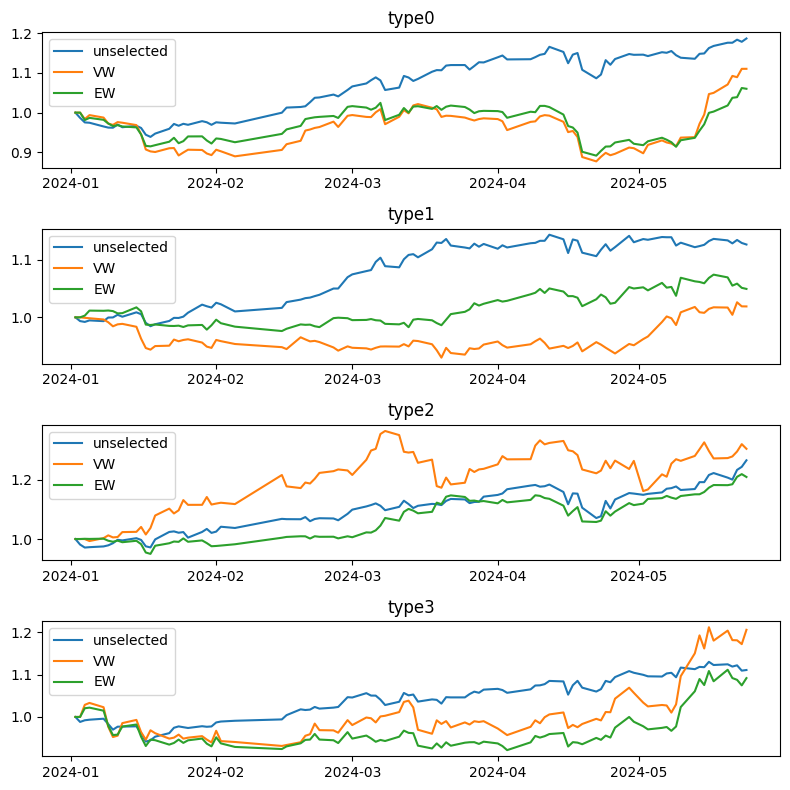

In [128]:
def getNavSeries(df_now_for_nav, weighting=[0.2] * 5, nav_current = 1):
    df2 = (1 + df_now_for_nav.pct_change()).cumprod()
    df3 = df2.fillna(1)
    df4 = df3*nav_current
    nav_series = np.sum(df4 * weighting, axis=1)
    return nav_series


with open(f"farrell_for2023_top100_cluster9_123.json", "r") as f:
    data = json.load(f)
list_key = list(data.keys())
pq = pd.read_parquet("price_top290.parquet")
pq['date'] = pq.index
start = "2024-01-01"
end = "2024-05-25"
analysis_df = pd.DataFrame()

fig, ax = plt.subplots(4, 1, figsize=(8, 8))
for i in range(len(list_key)):
    df_close_unpivoted = pq[pq['ticker'].isin(data[list_key[i]])]
    df_close_pivoted1 = pd.pivot_table(data=df_close_unpivoted, values='Close', index='date', columns='ticker')
    df_close_pivoted = df_close_pivoted1[df_close_pivoted1.index <= start]


    df_factor = pd.DataFrame()
    df_list = []
    for ticker in list(df_close_pivoted.columns):
        ym = main(ticker)
        r = np.polyfit(np.arange(0, len(ym), 1), ym, 1)[0]
        df_list.append(r)
    a = pd.DataFrame(df_list).T
    a.columns = df_close_pivoted.columns
    all_regression_data = a.T.sort_values(by=0, ascending=False)
    top10 = all_regression_data[:5]
    top10_20230101 = list(top10.index)
    top10 = top10.iloc[:, 0]

    weighting_based_on_r = top10/sum(top10)
    df_forwardtest = pq[pq['ticker'].isin(top10_20230101)]
    df_forwardtest = pd.pivot_table(data=df_forwardtest, values='Close', index='date', columns='ticker')
    plot_data = df_forwardtest[(df_forwardtest.index >= start) & (df_forwardtest.index <= end)]
    plot_data = (1 + plot_data.pct_change()).cumprod()
    plot_data_all_nav = (1 + plot_data.pct_change()).cumprod()
    nav = getNavSeries(plot_data, weighting_based_on_r)
    nav_ew = getNavSeries(plot_data)

    plot_data_all = df_close_pivoted1[(df_close_pivoted1.index >= start) & (df_close_pivoted1.index <= end)]
    nav_all = getNavSeries(plot_data_all, [1/len((plot_data_all.columns))]*len((plot_data_all.columns)))
    # plt.plot(plot_data)
    ax[i].plot(nav_all, label='unselected')
    ax[i].plot(nav, label='VW')
    ax[i].plot(nav_ew, label="EW")
    ax[i].legend()
    ax[i].set_title(f"type{i}")
    analysis_df[list_key[i]] = [nav_all[-1], nav_ew[-1], nav[-1]]
analysis_df = analysis_df.T
analysis_df.columns = ["unselected", "equal_weighted", "factor_weighted"]
analysis_df['diff'] = analysis_df['factor_weighted'] - analysis_df['unselected']

plt.tight_layout()
fig.savefig("backtest_png/"+start+end+"_class.png")
analysis_df.sort_values(by='diff', ascending=False)

In [101]:
plot_data_all.columns

Index(['0050', '006208', '1590', '2303', '2308', '2353', '2357', '2382',
       '2454', '3034', '3324', '4966', '5274', '5347', '6223', '6531', '6669',
       '6679'],
      dtype='object', name='ticker')

In [77]:

plot_data_all = df_close_pivoted1[(df_close_pivoted1.index >= "2023-01-01") & (df_close_pivoted1.index <= "2023-04-01")]
plot_data_all = (1 + plot_data_all.pct_change()).cumprod()
plot_data_all.plot()
plot_data_all.iloc[-1, :].mean()
all_regression_data


ValueError: Unable to coerce to Series, length must be 30: given 10